---
format: 
  html:
    toc: false
    page-layout: full
execute:
    echo: true
    warning: false
    output: true
---

In [ ]:
# install packages if needed
#%pip install libpysal
#%pip install esda
#%pip install census

import os
import requests
import zipfile
import pysal
import esda
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import folium
import cenpy as c
import osmnx as ox
import seaborn as sns
from IPython.display import display, HTML
from folium.plugins import TimeSliderChoropleth
from census import Census
from us import states
from sklearn.preprocessing import QuantileTransformer
from shapely.geometry import Point, LineString
from esda.moran import Moran_Local
from libpysal.weights import Queen
from shapely.ops import nearest_points

# Further data processing and viz.

### Obtain and process geographic data

Now, we will import Philadelphia census tracts to aggregate the crash data and more clearly visualize areas that suffer from more non-motorist crashes. We will calculate two metrics for total crashes per census tract: by land area (sq. km) and by drivable road length (km). We will also use a queen matrix to calculate the spatial lag of crashes for modeling later.

In [5]:
# read non motorist crash file from previous notebook
non_motorist_gdf = gpd.read_file("non_motorist_gdf.geojson")

# fetch tracts for Philadelphia
tract_url = "https://opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson"
geo_data = gpd.read_file(tract_url).set_crs("EPSG:4326")

# create a city boundary envelope
city_boundary = geo_data.unary_union.envelope

# fetch road network for Philadelphia
G = ox.graph_from_polygon(city_boundary, network_type="drive")

# create objects for nodes and edges respectively
nodes, edges = ox.graph_to_gdfs(G)

# filter out footways
edges = edges[edges["highway"] != "footway"]

# set crs to WGS 1984
edges = edges.to_crs(epsg=4326)

# join non-motorist crashes with census tracts
non_motorist_gdf = non_motorist_gdf.to_crs("EPSG:4326")
tracts_with_crashes = gpd.sjoin(geo_data, non_motorist_gdf, how="left", predicate="contains")

# join road segments with census tracts
roads_with_tracts = gpd.sjoin(edges, geo_data, how="inner", predicate="intersects")

# count crashes per tract
crash_counts = tracts_with_crashes.groupby("GEOID10").size().reset_index(name="crash_count")

# calculate total road length per tract
roads_with_tracts["length_km"] = roads_with_tracts.geometry.length / 1000  # Convert to kilometers
road_lengths = roads_with_tracts.groupby("GEOID10")["length_km"].sum().reset_index()

# merge metrics with geo_data
geo_data = (
    geo_data.merge(crash_counts, on="GEOID10", how="left")
    .merge(road_lengths, on="GEOID10", how="left")
)

# fill missing values
geo_data["crash_count"] = geo_data["crash_count"].fillna(0)
geo_data["length_km"] = geo_data["length_km"].fillna(0)

# convert nodes to gdf
nodes_gdf = gpd.GeoDataFrame(nodes, geometry='geometry', crs='EPSG:4326')
nodes_gdf = nodes_gdf.to_crs(geo_data.crs)

# spatial join to count intersections per tract
intersections_per_tract = gpd.sjoin(nodes_gdf, geo_data, how='inner', op='within')
intersections_count = intersections_per_tract.groupby('GEOID10').size().reset_index(name='intersection_count')
geo_data = geo_data.merge(intersections_count, on='GEOID10', how='left')
geo_data['intersection_count'] = geo_data['intersection_count'].fillna(0)

# calculate crashes per km and normalize crashes per sq km
geo_data["crashes_per_km"] = geo_data["crash_count"] / geo_data["length_km"].replace(0, pd.NA)
geo_data["crashes_per_sqkm"] = geo_data["crash_count"] / (geo_data["ALAND10"] / 1e6)

# replace NA with 0 after calculations
geo_data["crashes_per_km"] = geo_data["crashes_per_km"].fillna(0)
geo_data["crashes_per_sqkm"] = geo_data["crashes_per_sqkm"].fillna(0)

# calculate quintiles for each metric
geo_data["quintile_land"] = pd.qcut(geo_data["crashes_per_sqkm"], q=5, labels=range(1, 6)).astype(int)
geo_data["quintile_road"] = pd.qcut(geo_data["crashes_per_km"], q=5, labels=range(1, 6)).astype(int)

# group by GEOID10 and CRASH_YEAR to get crash counts per year for each tract
crash_counts_by_year = tracts_with_crashes.groupby(["GEOID10", "CRASH_YEAR"]).size().reset_index(name="crash_count_year")

# pivot the crash counts by year to wider format
crash_counts_pivot = crash_counts_by_year.pivot(index="GEOID10", columns="CRASH_YEAR", values="crash_count_year").reset_index()

# rename columns to have the stub "crash_"
crash_counts_pivot.columns = ["GEOID10"] + [f"crash_{int(col)}" for col in crash_counts_pivot.columns[1:]]

# merge the pivoted crash counts with geo_data
geo_data = geo_data.merge(crash_counts_pivot, on="GEOID10", how="left")

# fill missing values for crash counts by year
geo_data = geo_data.fillna(0)

# calculate spatial lag of crashes for each year
w = Queen.from_dataframe(geo_data)
for year in crash_counts_pivot.columns[1:]:
    geo_data[f"{year}_lag"] = w.sparse * geo_data[year]


/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/songj/miniforge3/envs/musa-550-fall-2024/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/var/folders/xd/w__5x95d37b_lkks4djd2m9h0000gp/T/ipykernel_86656/2471641250.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' t

In [6]:
# create styling function

def style_function_land(feature):
    quintile = feature["properties"]["quintile_land"]
    color_map = {
        1: "#deebf7",
        2: "#9ecae1",
        3: "#6baed6",
        4: "#3182bd",
        5: "#08519c",
    }
    color = color_map[quintile]
    return {
        "fillOpacity": 0.7,
        "weight": 0.5,
        "color": "black",
        "fillColor": color,
    }

def style_function_road(feature):
    quintile = feature["properties"]["quintile_road"]
    color_map = {
        1: "#fee5d9",
        2: "#fcae91",
        3: "#fb6a4a",
        4: "#de2d26",
        5: "#a50f15",
    }
    color = color_map[quintile]
    return {
        "fillOpacity": 0.7,
        "weight": 0.5,
        "color": "black",
        "fillColor": color,
    }

# create map for crashes per sq km
m_land = folium.Map(location=[39.9526, -75.1652], zoom_start=12, tiles="cartodb positron")
folium.GeoJson(
    geo_data.to_json(),
    style_function=style_function_land,
    tooltip=folium.GeoJsonTooltip(
        fields=["GEOID10", "crash_count", "crashes_per_sqkm"],
        aliases=["Tract", "Crash Count", "Crashes per Sq Km"],
    ),
).add_to(m_land)

# create map for crashes per km of road
m_road = folium.Map(location=[39.9526, -75.1652], zoom_start=12, tiles="cartodb positron")
folium.GeoJson(
    geo_data.to_json(),
    style_function=style_function_road,
    tooltip=folium.GeoJsonTooltip(
        fields=["GEOID10", "crash_count", "length_km", "crashes_per_km"],
        aliases=["Tract", "Crash Count", "Road Length (km)", "Crashes per km"],
    ),
).add_to(m_road)

## Visualizing maps of crashes per census tract

We will now visualize maps of the two crashes per tract metrics.

### All crashes by census tract, normalized by land area (sq. km.)

In [7]:
m_land  # display crashes per land area

### All crashes by census tract, normalized by road length (km)

In [8]:
m_road  # display crashes per road km


By comparing the two maps, we can see that the spatial distribution of the two metrics are quite similar, with the greatest burden of crashes in Center City, Kensington, and West Philadelphia, as well as along Broad Street, an important north-south arterial road.

## Further data processing and collection

We will process our data further by calculating the proportion of tertiary and residential roads in each census tract.

In [9]:
# select residential and tertiary roads
residential_edges = edges[edges["highway"] == "residential"]
tertiary_edges = edges[edges["highway"] == "tertiary"]

# ensure geo_data is in the same CRS as edges
geo_data = geo_data.to_crs(edges.crs)

# spatial join all roads with census tracts
edges_with_tract = gpd.sjoin(edges, geo_data, how="inner", predicate="intersects")

# spatial join only residential roads with census tracts
residential_edges_with_tract = gpd.sjoin(residential_edges, geo_data, how="inner", predicate="intersects")

# spatial join only tertiary roads with census tracts
tertiary_edges_with_tract = gpd.sjoin(tertiary_edges, geo_data, how="inner", predicate="intersects")

# summarize total road length per tract
total_length_by_tract = (
    edges_with_tract.groupby("GEOID10")["length"]
    .sum()
    .reset_index(name="total_length")
)

# total residential road length per tract
residential_length_by_tract = (
    residential_edges_with_tract.groupby("GEOID10")["length"]
    .sum()
    .reset_index(name="residential_length")
)

# total tertiary road length per tract
tertiary_length_by_tract = (
    tertiary_edges_with_tract.groupby("GEOID10")["length"]
    .sum()
    .reset_index(name="tertiary_length")
)

# merge total lengths, residential lengths and merge tertiary lengths
geo_data = geo_data.merge(total_length_by_tract, on="GEOID10", how="left")
geo_data = geo_data.merge(residential_length_by_tract, on="GEOID10", how="left")
geo_data = geo_data.merge(tertiary_length_by_tract, on="GEOID10", how="left")

# calculate the proportion of residential roads
geo_data["residential_proportion"] = geo_data["residential_length"] / geo_data["total_length"]

# calculate the proportion of tertiary roads
geo_data["tertiary_proportion"] = geo_data["tertiary_length"] / geo_data["total_length"]

# handle missing values
geo_data["residential_proportion"] = geo_data["residential_proportion"].fillna(0)
geo_data["tertiary_proportion"] = geo_data["tertiary_proportion"].fillna(0)


### ACS data

We will also collect data from the ACS 2022 5-year estimates on commuting characteristics and vehicle ownership, as well as economic and racial/ethnic demographics. In detail, they are as follows:

- Commuting

    - Drive alone

    - Carpool

    - Public transit

    - Walking

    - Biking

    - Work from home

- Vehicle ownership

    - None

    - One

    - Two

    - Three or more (excluded from analysis)

- Economics

    - Median household income

    - Poverty rate

- Race/ethnicity

    - White

    - Black

    - Hispanic/Latinx

    - Asian

In [19]:
# set census API key
CENSUS_API_KEY = "811e1f6f8d1f299cb75a0f0c07e01aafd801fa79"
c = Census(CENSUS_API_KEY)

# define FIPS codes for Philadelphia
STATE_FIPS = states.PA.fips
COUNTY_FIPS = "101"

# define ACS variables to pull
acs_variables = {
    "comm_total": "B08006_001E",
    "commute_drive_alone": "B08006_003E",
    "commute_carpool": "B08006_004E",
    "commute_public_transport": "B08006_008E",
    "commute_walked": "B08006_015E",
    "commute_bike": "B08006_014E",
    "commute_work_from_home": "B08006_017E",
    "veh_total": "B25044_001E",
    "vehicle_none_owner": "B25044_003E",
    "vehicle_one_owner": "B25044_004E",
    "vehicle_two_owner": "B25044_005E",
    "vehicle_three_owner": "B25044_006E",
    "vehicle_four_owner": "B25044_007E",
    "vehicle_five_or_more_owner": "B25044_008E",
    "vehicle_none_renter": "B25044_010E",
    "vehicle_one_renter": "B25044_011E",
    "vehicle_two_renter": "B25044_012E",
    "vehicle_three_renter": "B25044_013E",
    "vehicle_four_renter": "B25044_014E",
    "vehicle_five_or_more_renter": "B25044_015E",
    "median_income": "B19013_001E",
    "pov_total": "B17001_001E",
    "poverty": "B17001_002E",
    "white_alone": "B02001_002E",
    "black_alone": "B02001_003E",
    "asian_alone": "B02001_005E",
    "hispanic": "B03003_003E",
    "total_population": "B02001_001E"
}

# fetch ACS data
acs_data = c.acs5.state_county_tract(
    fields=list(acs_variables.values()),
    state_fips=STATE_FIPS,
    county_fips=COUNTY_FIPS,
    tract="*",
    year=2022
)

# convert ACS data to df
acs_df = pd.DataFrame(acs_data)

# rename columns for clarity
acs_df.rename(columns={v: k for k, v in acs_variables.items()}, inplace=True)

# convert median_income values under 1 to 0
acs_df["median_income"] = acs_df["median_income"].apply(lambda x: 0 if x < 1 else x)

# add three, four, and five or more vehicles variables to get three or more vehicles
acs_df["vehicle_three_or_more_owner"] = (
    acs_df["vehicle_three_owner"] +
    acs_df["vehicle_four_owner"] +
    acs_df["vehicle_five_or_more_owner"]
)
acs_df["vehicle_three_or_more_renter"] = (
    acs_df["vehicle_three_renter"] +
    acs_df["vehicle_four_renter"] +
    acs_df["vehicle_five_or_more_renter"]
)

# combine owner and renter variables to create totals
acs_df["vehicle_none"] = (
    acs_df["vehicle_none_owner"] +
    acs_df["vehicle_none_renter"]
)
acs_df["vehicle_one"] = (
    acs_df["vehicle_one_owner"] +
    acs_df["vehicle_one_renter"]
)
acs_df["vehicle_two"] = (
    acs_df["vehicle_two_owner"] +
    acs_df["vehicle_two_renter"]
)
acs_df["vehicle_three_or_more"] = (
    acs_df["vehicle_three_or_more_owner"] +
    acs_df["vehicle_three_or_more_renter"]
)

# delete original variables
acs_df.drop(columns=[
    "vehicle_none_owner",
    "vehicle_one_owner",
    "vehicle_two_owner",
    "vehicle_three_owner",
    "vehicle_four_owner",
    "vehicle_five_or_more_owner",
    "vehicle_none_renter",
    "vehicle_one_renter",
    "vehicle_two_renter",
    "vehicle_three_renter",
    "vehicle_four_renter",
    "vehicle_five_or_more_renter",
    "vehicle_three_or_more_owner",
    "vehicle_three_or_more_renter"
], inplace=True)

In [20]:
# calculate percentages for demographic variables
acs_df["pct_white"] = acs_df["white_alone"] / acs_df["total_population"]
acs_df["pct_black"] = acs_df["black_alone"] / acs_df["total_population"]
acs_df["pct_asian"] = acs_df["asian_alone"] / acs_df["total_population"]
acs_df["pct_hispanic"] = acs_df["hispanic"] / acs_df["total_population"]
acs_df["pct_comm_drive_alone"] = acs_df["commute_drive_alone"] / acs_df["comm_total"]
acs_df["pct_comm_carpool"] = acs_df["commute_carpool"] / acs_df["comm_total"]
acs_df["pct_comm_transit"] = acs_df["commute_public_transport"] / acs_df["comm_total"]
acs_df["pct_comm_walk"] = acs_df["commute_walked"] / acs_df["comm_total"]
acs_df["pct_comm_bike"] = acs_df["commute_bike"] / acs_df["comm_total"]
acs_df["pct_comm_wfh"] = acs_df["commute_work_from_home"] / acs_df["comm_total"]
acs_df["pct_vehicle0"] = acs_df["vehicle_none"] / acs_df["veh_total"]
acs_df["pct_vehicle1"] = acs_df["vehicle_one"] / acs_df["veh_total"]
acs_df["pct_vehicle2"] = acs_df["vehicle_two"] / acs_df["veh_total"]
acs_df["pct_vehicle3plus"] = acs_df["vehicle_three_or_more"] / acs_df["veh_total"]
acs_df["pct_poverty"] = acs_df["poverty"] / acs_df["pov_total"]

# reconstruct GEOID10 in acs_df
acs_df["GEOID10"] = (
    acs_df["state"].astype(str).str.zfill(2) +
    acs_df["county"].astype(str).str.zfill(3) +
    acs_df["tract"].astype(str).str.zfill(6)
)

# merge ACS data into geo_data using GEOID10
geo_data_acs = geo_data.merge(acs_df, on="GEOID10", how="left")

# handle missing values
geo_data_acs.fillna(0, inplace=True)

# drop unnecessary columns
geo_data_acs.drop(columns=["state", "county", "tract"], inplace=True)

# save geo_data as a geojson file for next notebook
geo_data_acs.to_file("geo_data_crashes.geojson", driver="GeoJSON")

## Summarizing ACS data

As with many injury-related phenomena, motor vehicle injuries and non-motorist crashes show disparities in who they affect ([NHTSA](https://trid.trb.org/View/2021861)). We will describe this trend in Philadelphia using the data we pulled from the ACS.

### Histograms

First, we will produce a set of histograms to view the distributions of several ACS variables.

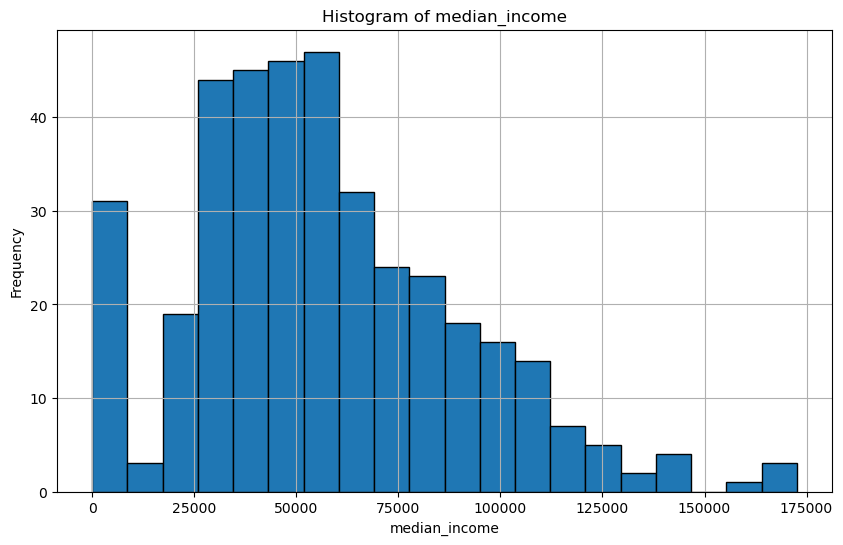

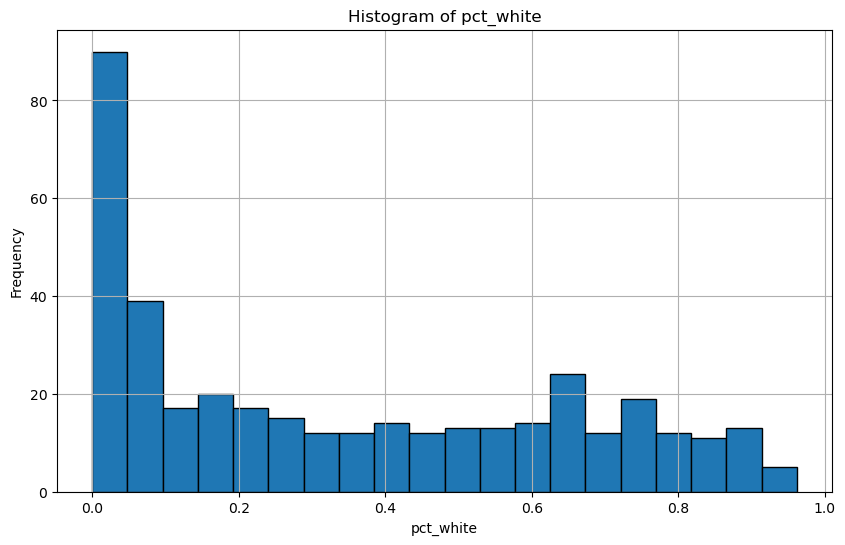

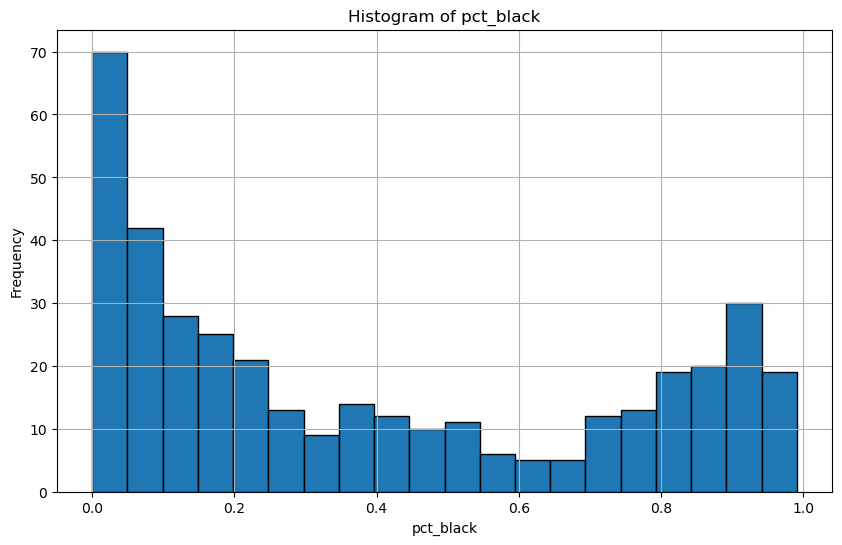

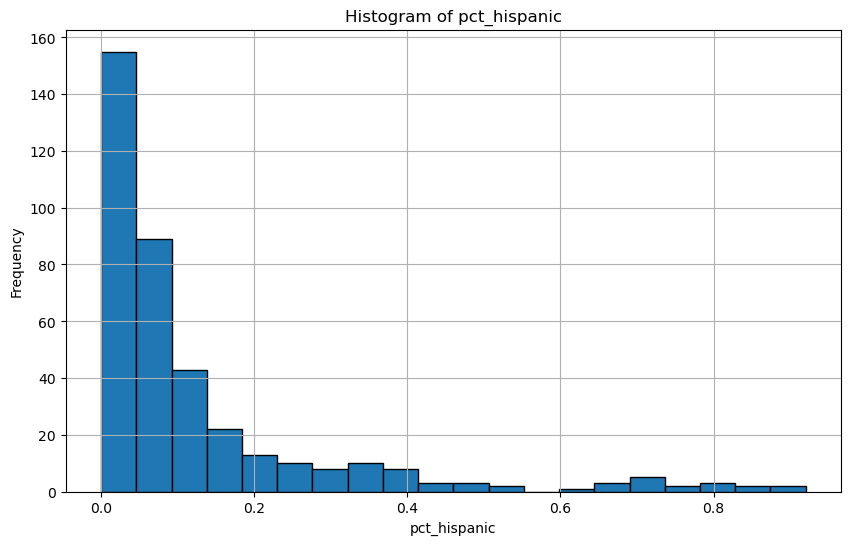

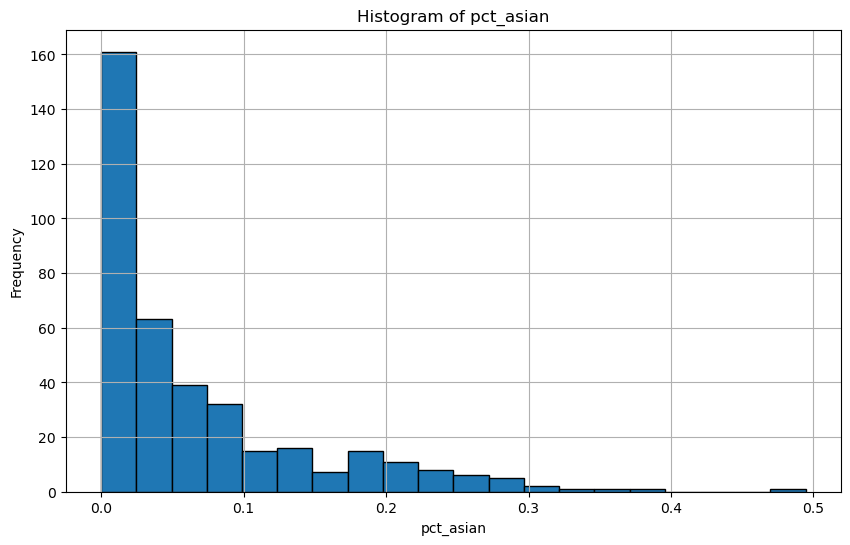

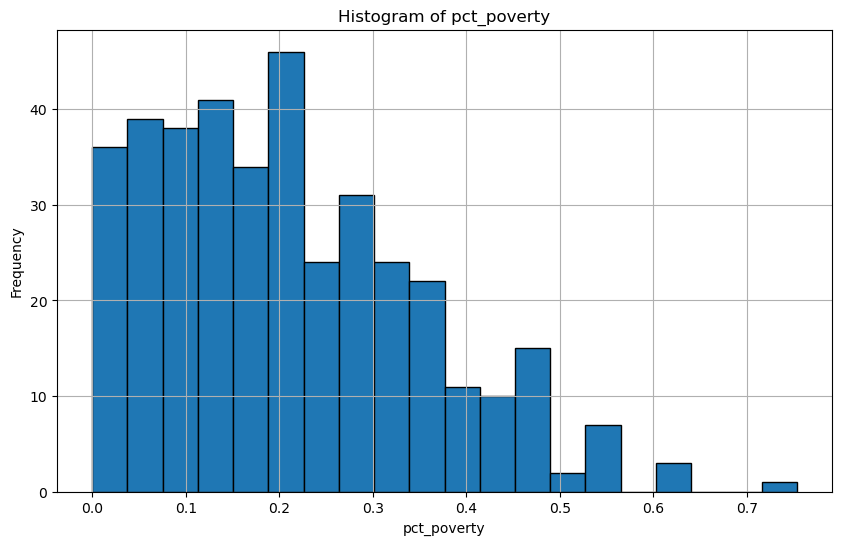

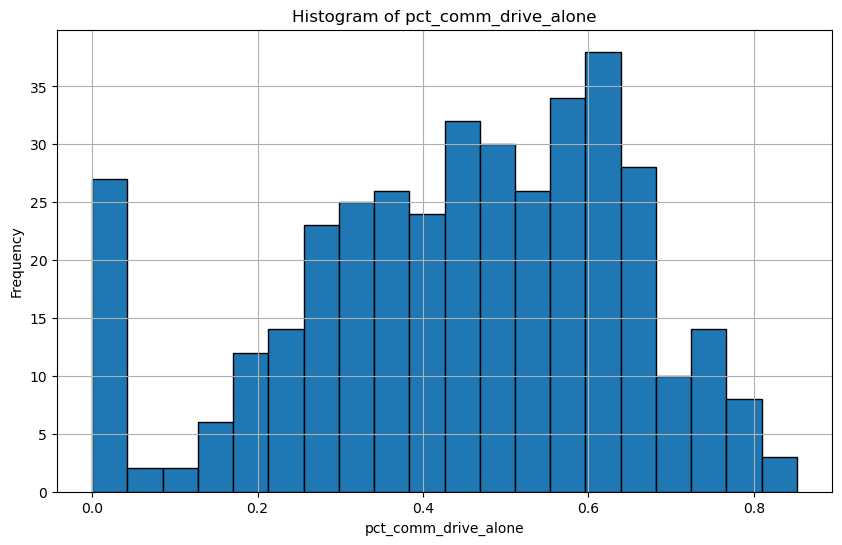

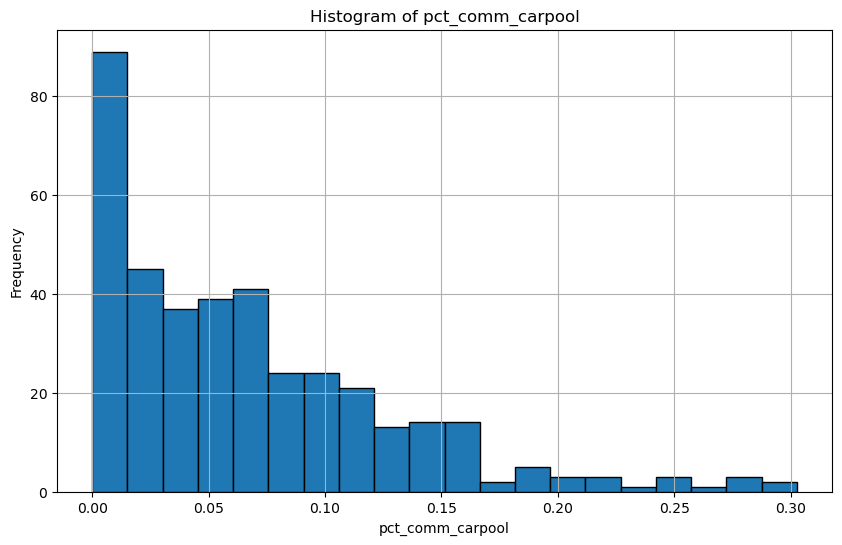

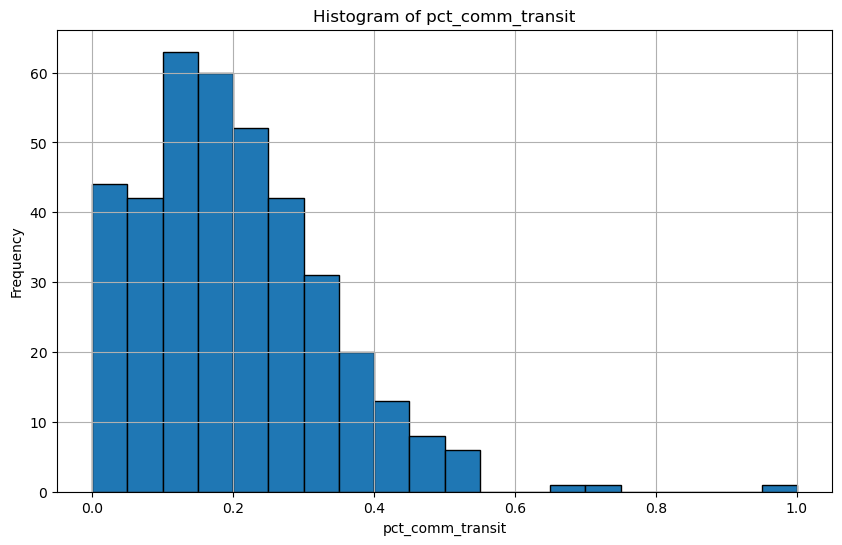

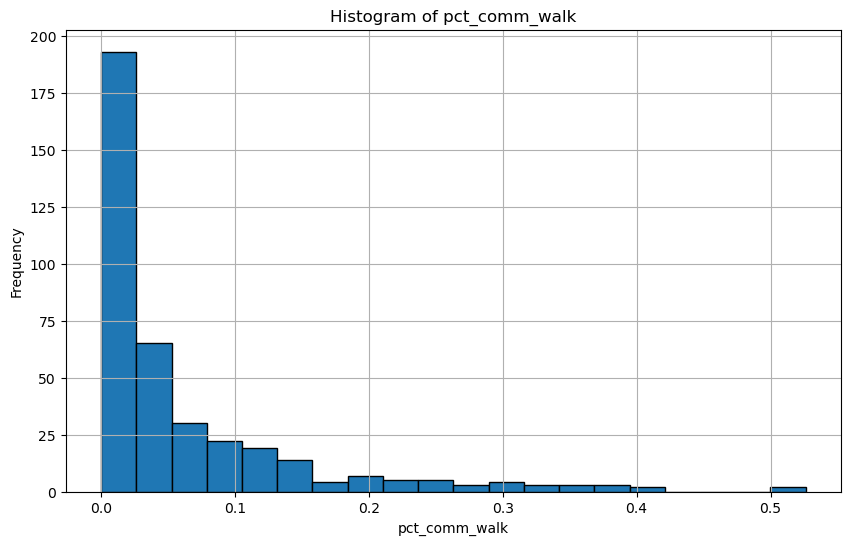

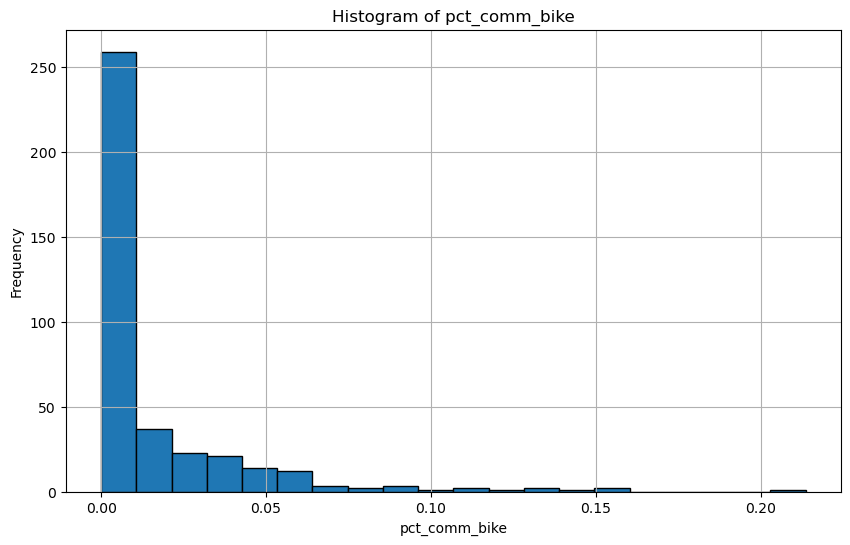

In [21]:
# list of demographic variables to plot
variables = [
    'median_income', 'pct_white', 'pct_black', 'pct_hispanic', 'pct_asian',
    'pct_poverty', 'pct_comm_drive_alone', 'pct_comm_carpool', 'pct_comm_transit',
    'pct_comm_walk', 'pct_comm_bike'
]

# create a histogram for each variable
for variable in variables:
    plt.figure(figsize=(10, 6))
    plt.hist(geo_data_acs[variable], bins=20, edgecolor='black')
    plt.title(f'Histogram of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

We can see that the racial/ethnic demographic variables as well as many of the commute-related variables do not have apparently normal distributions. To minimize the bias from skewed data, we will calculate median instead of mean for these.

### Summary table

The following table summarizes the ACS variables by quintile of crashes by road length (km) by census tract.

In [13]:
# multiply all percentage variables by 100
percentage_columns = [
    'pct_white', 'pct_black', 'pct_hispanic', 'pct_asian', 'pct_poverty',
    'pct_comm_drive_alone', 'pct_comm_carpool', 'pct_comm_transit',
    'pct_comm_walk', 'pct_comm_bike'
]
geo_data_acs[percentage_columns] = geo_data_acs[percentage_columns] * 100

# group by quintile and calculate the mean demographics for each quintile
quintile_demographics = geo_data_acs.groupby('quintile_road').agg({
    'median_income': 'mean',
    'pct_white': 'median',
    'pct_black': 'median',
    'pct_hispanic': 'median',
    'pct_asian': 'median',
    'pct_poverty': 'mean',
    'pct_comm_drive_alone': 'median',
    'pct_comm_carpool': 'median',
    'pct_comm_transit': 'median',
    'pct_comm_walk': 'median',
    'pct_comm_bike': 'median'
}).reset_index()

In [14]:
# rename columns to include the appropriate metric
quintile_demographics.rename(columns={
    'median_income': 'median income (mean)',
    'pct_white': 'pct white (median)',
    'pct_black': 'pct black (median)',
    'pct_hispanic': 'pct hispanic (median)',
    'pct_asian': 'pct asian (median)',
    'pct_poverty': 'pct poverty (mean)',
    'pct_comm_drive_alone': 'pct drive_alone (median)',
    'pct_comm_carpool': 'pct carpool (median)',
    'pct_comm_transit': 'pct transit (median)',
    'pct_comm_walk': 'pct walk (median)',
    'pct_comm_bike': 'pct bike (median)'
}, inplace=True)

# set display options
pd.set_option('display.precision', 2)
pd.set_option('display.colheader_justify', 'center')

# display df as an html table
display(HTML(quintile_demographics.to_html(index=False)))

quintile_road,median income (mean),pct white (median),pct black (median),pct hispanic (median),pct asian (median),pct poverty (mean),pct drive_alone (median),pct carpool (median),pct transit (median),pct walk (median),pct bike (median)
1,71703.79,59.82,15.30,5.35,3.32,11.99,60.75,6.77,12.02,1.01,0.00
2,55323.21,27.46,28.12,5.87,2.53,16.77,52.47,6.46,14.20,2.16,0.00
3,59099.29,25.49,30.68,8.17,3.96,22.49,44.64,6.98,18.50,2.52,0.00
4,47287.19,10.13,56.15,6.64,3.24,26.89,43.46,5.42,23.37,3.48,0.00
5,49366.47,22.62,26.49,5.40,4.94,26.36,29.14,2.61,23.60,6.43,1.34


Tracts in lower quintiles of crashes per road length have higher median incomes, white populations, and rates of commuting to work in cars, while tracts in higher quintiles have lower median incomes, greater Black, Hispanic, and Asian populations, and higher rates of commuting to work by public transit, walking, and biking. This suggests that more marginalized communities bear a greater burden of non-motorist crash injuries. 

However, there is an important limitation to consider: the neighborhood characteristics of crash locations are not the same as those of the people injured in the crashes. This limitation is tempered by the fact that we are studying non-motorist crashes; in particular, injured non-motorists are more likely to be from nearby areas by virtue of their slower modes of transportation.